In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, TimeDistributed, GlobalAveragePooling1D, Masking
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

2025-03-14 00:08:52.654960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 00:08:52.674879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741936132.691943  306949 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741936132.697038  306949 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 00:08:52.720729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def convert_percentage_to_float(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.rstrip('%')
        df[col] = pd.to_numeric(df[col], errors='coerce') / 100
        df[col] = df[col].round(3)
    return df

def convert_object_to_float(df, columns):
    for col in columns:
        df[col] = df[col].replace('-', 0)
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    return df

def parse_duration(s):
    if isinstance(s, str) and ":" in s:
        mins, secs = s.split(":")
        return int(mins) * 60 + int(secs)
    return float(s) if s == s else None

In [3]:
df1 = pd.read_csv("players_stats.csv")
df2 = pd.read_csv("rosters.csv")
df_players = pd.merge(df1, df2[['Player', 'Season', 'Team']], on=['Player', 'Season'], how='left')

#df_players["Win rate"] = df_players["Win rate"].str.rstrip("%").astype(float) / 100
df_players.drop(columns=["Country"], inplace=True)
df_players = df_players[df_players["VSPM"] != "-"]
df_players = df_players[df_players["KDA"] != "-"]
#df_players['Solo Kills'] = df_players['Solo Kills'].replace('-', 0)
percentage_columns = ["Win rate", "KP%", "DMG%", "FB %", "FB Victim"]
object_columns = ["KDA", "Solo Kills"]
df_players = convert_percentage_to_float(df_players, percentage_columns)
df_players = convert_object_to_float(df_players, object_columns)
df_players.reset_index(drop=True, inplace=True)

df_players.head(10)

,Player,Season,Position,Games,Win rate,KDA,Avg kills,Avg deaths,Avg assists,CSM,...,Avg WCPM,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Penta Kills,Solo Kills,Team
0,ADD,S8,TOP,96,0.323,2.0,1.2,2.4,3.6,8.9,...,0.22,0.20,-80,-5,-181,0.198,0.198,0,11.0,MVP
1,Brook,S8,TOP,1,0.000,3.5,3.0,2.0,4.0,8.8,...,0.42,0.10,771,16,-38,1.000,0.000,0,0.0,Hanwha Life eSports
2,Crazy,S8,TOP,92,0.293,2.7,1.7,1.8,3.0,8.7,...,0.20,0.17,-92,1,-79,0.141,0.130,0,11.0,bbq Olivers
3,CuVee,S8,TOP,105,0.571,2.5,1.7,2.1,3.4,9.2,...,0.21,0.21,-86,-3,-41,0.181,0.114,0,19.0,Gen.G eSports
4,CuVee,S8,TOP,105,0.571,2.5,1.7,2.1,3.4,9.2,...,0.21,0.21,-86,-3,-41,0.181,0.114,0,19.0,KSV eSports
5,Khan,S8,TOP,83,0.699,3.8,2.4,1.7,4.1,9.6,...,0.25,0.23,240,7,159,0.229,0.120,1,19.0,Kingzone DragonX
6,Kiin,S8,TOP,106,0.613,3.9,2.2,1.5,3.8,9.7,...,0.20,0.16,147,4,135,0.198,0.132,0,23.0,Afreeca Freecs
7,Kiin,S8,TOP,106,0.613,3.9,2.2,1.5,3.8,9.7,...,0.20,0.16,147,4,135,0.198,0.132,0,23.0,Ever8 Winners
8,Lindarang,S8,TOP,90,0.522,2.6,1.8,2.2,3.9,8.6,...,0.13,0.13,22,-4,-134,0.322,0.144,0,9.0,Hanwha Life eSports
9,Lindarang,S8,TOP,90,0.522,2.6,1.8,2.2,3.9,8.6,...,0.13,0.13,22,-4,-134,0.322,0.144,0,9.0,ROX Tigers


In [4]:
df_teams = pd.read_csv("teams_stats.csv")

df_teams.drop(columns=["Region", "FOS%", "VGPG", "ATAKHAN%", "PPG"], inplace=True)
percentage_columns = ["Win rate"]
percentage = ["FB%", "FT%", "DRA%", "HER%", "NASH%"]
df_teams[percentage] = df_teams[percentage].apply(lambda x: x / 100)
df_teams[percentage] = df_teams[percentage].apply(lambda col: col.round(3))
df_teams = convert_percentage_to_float(df_teams, percentage_columns)
df_teams["Game duration"] = df_teams["Game duration"].apply(parse_duration)
df_teams = df_teams[~df_teams['Season'].isin(['S6', 'S7'])]
df_teams.reset_index(drop=True, inplace=True)

df_teams.head(10)

,Team,Season,Games,Win rate,K:D,GPM,GDM,Game duration,Kills / game,Deaths / game,...,DRA@15,TD@15,GD@15,NASHPG,NASH%,CSM,DPM,WPM,VWPM,WCPM
0,Afreeca Freecs,S8,106,0.613,1.26,1855,104,2220,9.6,7.6,...,0.49,0.1,355,1.02,0.595,36.9,1685,4.7,1.54,2.04
1,bbq Olivers,S8,92,0.293,0.81,1706,-165,2248,7.7,9.5,...,0.30,-0.3,-544,0.74,0.369,35.0,1563,4.2,1.39,1.66
2,DAMWON Gaming,S8,6,0.833,1.49,1866,178,2251,14.7,9.8,...,0.83,-0.2,-493,0.67,0.583,34.6,1954,3.5,1.49,1.65
3,Ever8 Winners,S8,6,0.333,0.67,1640,-259,2355,7.5,11.2,...,0.50,-0.5,-2183,0.50,0.222,35.2,1388,4.4,1.54,1.55
4,Gen.G eSports,S8,59,0.627,1.07,1805,94,2080,8.8,8.2,...,0.73,0.2,693,0.69,0.576,35.6,1668,3.4,1.49,1.67
5,Griffin,S8,62,0.645,1.61,1835,123,2162,11.1,6.8,...,0.45,-0.1,-35,0.82,0.641,36.3,1738,3.5,1.35,1.71
6,Hanwha Life eSports,S8,46,0.543,1.00,1781,30,2036,9.3,9.3,...,0.63,0.3,-75,0.76,0.617,34.3,1667,3.7,1.41,1.58
7,Jin Air Green Wings,S8,89,0.371,0.90,1744,-91,2308,8.3,9.3,...,0.57,-0.1,-347,0.62,0.385,36.2,1704,4.2,1.30,1.84
8,Kingzone DragonX,S8,94,0.691,1.36,1895,192,2115,11.0,8.1,...,0.72,0.3,734,0.91,0.691,37.1,1830,4.3,1.32,1.86
9,Kongdoo Monster,S8,51,0.255,0.65,1689,-246,2248,7.3,11.2,...,0.39,0.0,-696,0.63,0.286,35.1,1629,4.5,1.40,1.74


In [24]:
X = df_teams.drop(['Team', 'Season', 'Win rate'], axis=1)   # drop non-numeric and target columns
y = df_teams['Win rate']

# Split into 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

rf = RandomForestRegressor(n_estimators=132, random_state=42)
rf.fit(X_train_scaled, y_train)

xgb = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
xgb.fit(X_train_scaled, y_train)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')  # linear output for regression
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.1, verbose=0)

/home/richardc/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Define a helper function to compute RMSE and R²
def evaluate_model(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return rmse, r2

# Evaluate Linear Regression
y_pred_lin = lin_reg.predict(X_test_scaled)
rmse_lin, r2_lin = evaluate_model(y_test, y_pred_lin)
print(f"Linear Regression: RMSE = {rmse_lin:.3f}, R^2 = {r2_lin:.3f}")

# Evaluate Random Forest
y_pred_rf = rf.predict(X_test_scaled)
rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest:      RMSE = {rmse_rf:.3f}, R^2 = {r2_rf:.3f}")

# Evaluate XGBoost
y_pred_xgb = xgb.predict(X_test_scaled)
rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb)
print(f"XGBoost:            RMSE = {rmse_xgb:.3f}, R^2 = {r2_xgb:.3f}")

# Evaluate Neural Network
y_pred_nn = model.predict(X_test_scaled).ravel()
rmse_nn, r2_nn = evaluate_model(y_test, y_pred_nn)
print(f"Neural Network:     RMSE = {rmse_nn:.3f}, R^2 = {r2_nn:.3f}")

Linear Regression: RMSE = 0.053, R^2 = 0.897
Random Forest:      RMSE = 0.055, R^2 = 0.891
XGBoost:            RMSE = 0.060, R^2 = 0.871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Neural Network:     RMSE = 0.227, R^2 = -0.864



Linear Regression Coefficients:
          Feature  Coefficient
8     Towers lost    -0.047644
3             GDM     0.042084
7   Towers killed     0.039799
11          DRAPG    -0.028427
5    Kills / game     0.025063
12           DRA%     0.023824
17         NASHPG     0.017774
1             K:D     0.017371
0           Games    -0.015346
14         DRA@15     0.009265
15          TD@15    -0.008638
16          GD@15    -0.007723
2             GPM     0.007686
20            DPM    -0.007566
13           HER%     0.006052
19            CSM    -0.005300
9             FB%    -0.005116
22           VWPM     0.004555
18          NASH%    -0.002758
4   Game duration     0.002658
10            FT%    -0.002528
6   Deaths / game    -0.001645
23           WCPM     0.001231
21            WPM     0.000633


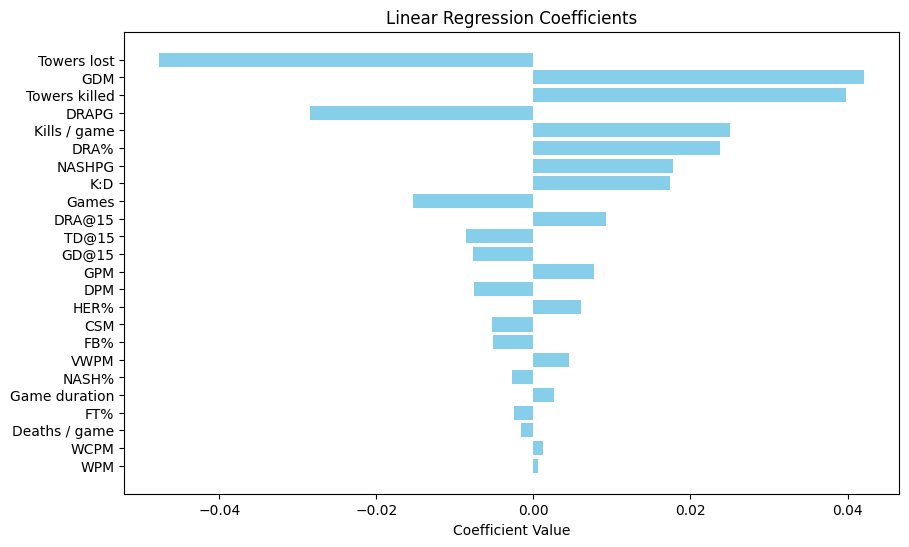

In [7]:
# (a) Linear Regression: Plot coefficients
importances_lin = lin_reg.coef_
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': importances_lin})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
print("\nLinear Regression Coefficients:")
print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()

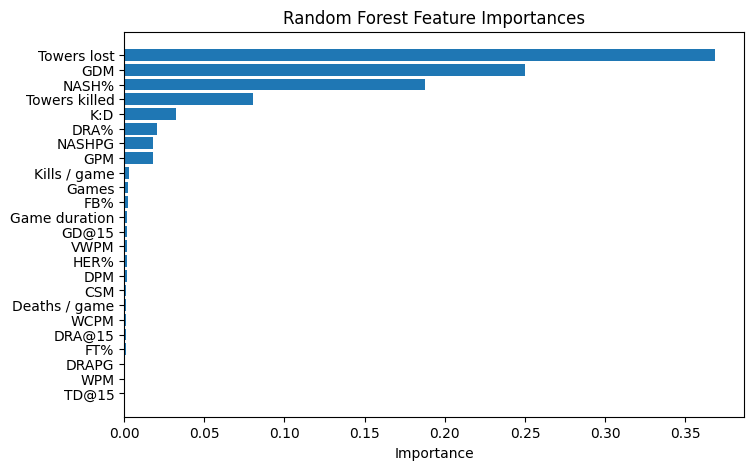

In [8]:
# (b) Feature Importance for Random Forest
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
top_features_rf = features[indices_rf]

plt.figure(figsize=(8, 5))
plt.barh(range(len(features)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(features)), top_features_rf)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

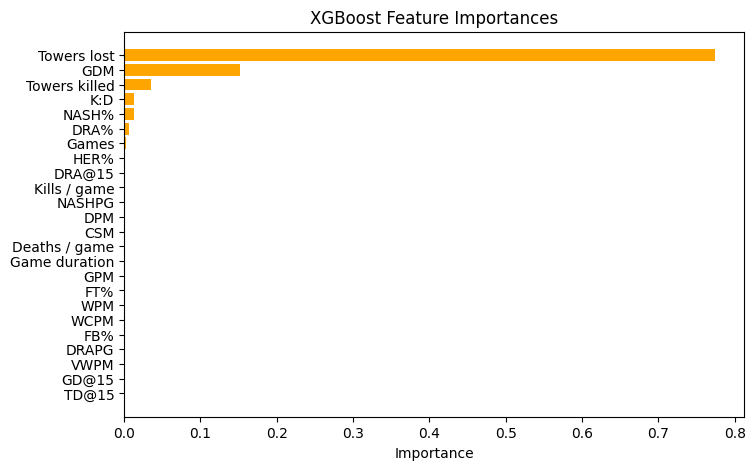

In [9]:
# (c) Feature Importance for XGBoost
importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
top_features_xgb = features[indices_xgb]

plt.figure(figsize=(8, 5))
plt.barh(range(len(features)), importances_xgb[indices_xgb], align='center', color='orange')
plt.yticks(range(len(features)), top_features_xgb)
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.show()

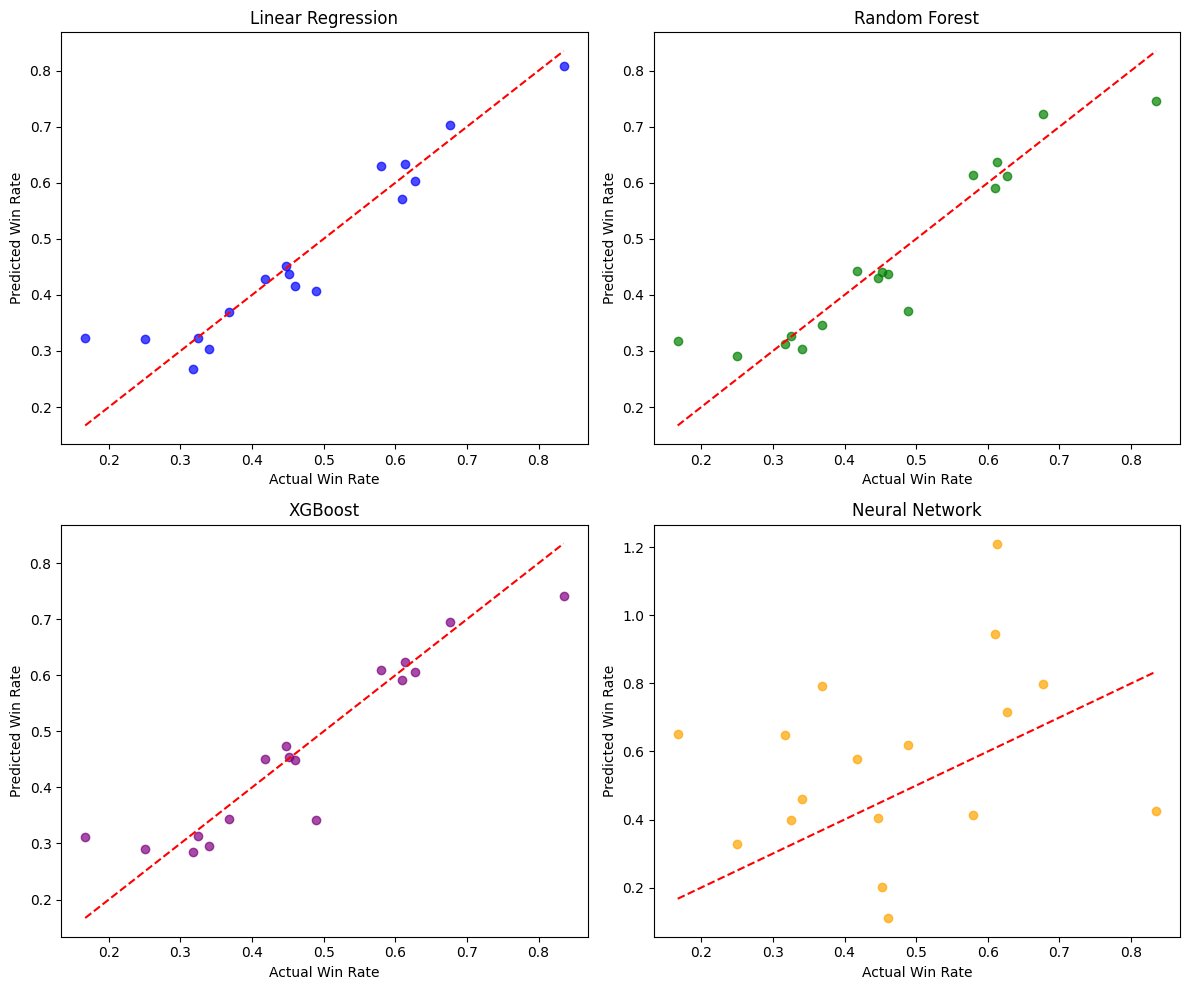

In [10]:
# (d) Predicted vs Actual Win Rates on Test Set (2x2 grid for the 4 models)
plt.figure(figsize=(12, 10))

# Linear Regression Plot
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Linear Regression")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

# Random Forest Plot
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

# XGBoost Plot
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, color='purple', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("XGBoost")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

# Neural Network Plot
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_nn, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Neural Network")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

plt.tight_layout()
plt.show()

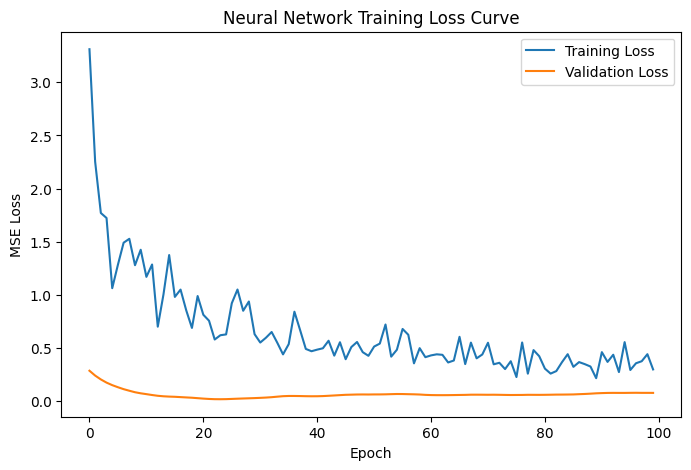

In [11]:
# (e) Neural Network Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network Training Loss Curve")
plt.legend()
plt.show()

In [12]:
# --- Model 1: Ridge Regression ---
ridge = Ridge()
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train_scaled, y_train)
best_ridge = grid_ridge.best_estimator_
# (Do not print parameters here.)

# --- Model 2: Random Forest Regressor ---
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

# --- Model 3: XGBoost Regressor ---
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_xgb.fit(X_train_scaled, y_train)
best_xgb = grid_xgb.best_estimator_

# --- Model 4: Neural Network (MLP) with TensorFlow ---
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),  # increased dropout for better regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='linear')
])
nn_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = nn_model.fit(X_train_scaled, y_train, epochs=200, batch_size=16, 
                       validation_split=0.1, callbacks=[early_stop], verbose=0)

/home/richardc/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
def evaluate_model(model, X_test, y_test, is_nn=False):
    if is_nn:
        y_pred = model.predict(X_test).ravel()
    else:
        y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return y_pred, rmse, r2

# Evaluate each model on the test set:
y_pred_ridge, rmse_ridge, r2_ridge = evaluate_model(best_ridge, X_test_scaled, y_test)
y_pred_rf, rmse_rf, r2_rf = evaluate_model(best_rf, X_test_scaled, y_test)
y_pred_xgb, rmse_xgb, r2_xgb = evaluate_model(best_xgb, X_test_scaled, y_test)
y_pred_nn, rmse_nn, r2_nn = evaluate_model(nn_model, X_test_scaled, y_test, is_nn=True)

print("Test Set Evaluation:")
print(f"Ridge Regression:     RMSE = {rmse_ridge:.3f}, R² = {r2_ridge:.3f}")
print(f"Random Forest:        RMSE = {rmse_rf:.3f}, R² = {r2_rf:.3f}")
print(f"XGBoost:              RMSE = {rmse_xgb:.3f}, R² = {r2_xgb:.3f}")
print(f"Neural Network (MLP): RMSE = {rmse_nn:.3f}, R² = {r2_nn:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Test Set Evaluation:
Ridge Regression:     RMSE = 0.054, R² = 0.895
Random Forest:        RMSE = 0.055, R² = 0.888
XGBoost:              RMSE = 0.059, R² = 0.874
Neural Network (MLP): RMSE = 0.289, R² = -2.018


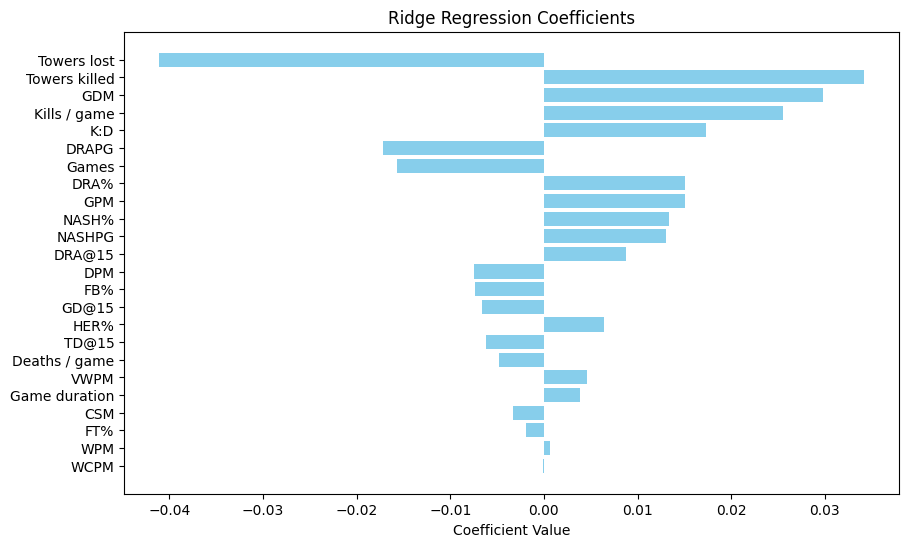

In [14]:
# (a) Linear Regression Coefficients
lin_coefs = best_ridge.coef_
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': lin_coefs})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Ridge Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()


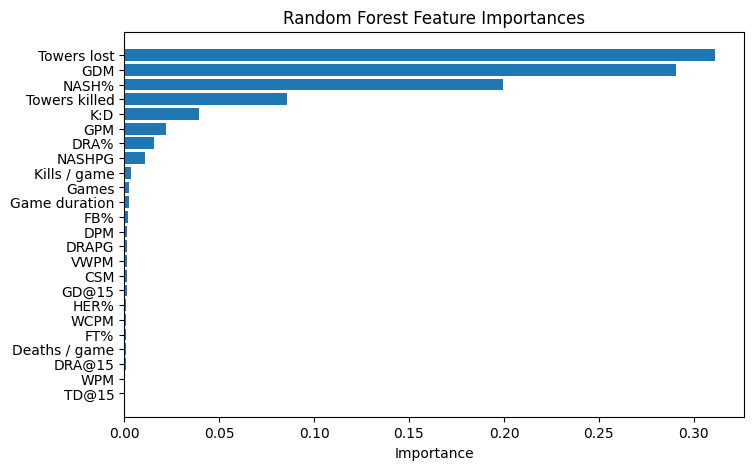

In [15]:
# (b) Random Forest Feature Importances
rf_importances = best_rf.feature_importances_
indices_rf = np.argsort(rf_importances)[::-1]
plt.figure(figsize=(8, 5))
plt.barh(range(len(features)), rf_importances[indices_rf], align='center')
plt.yticks(range(len(features)), features[indices_rf])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

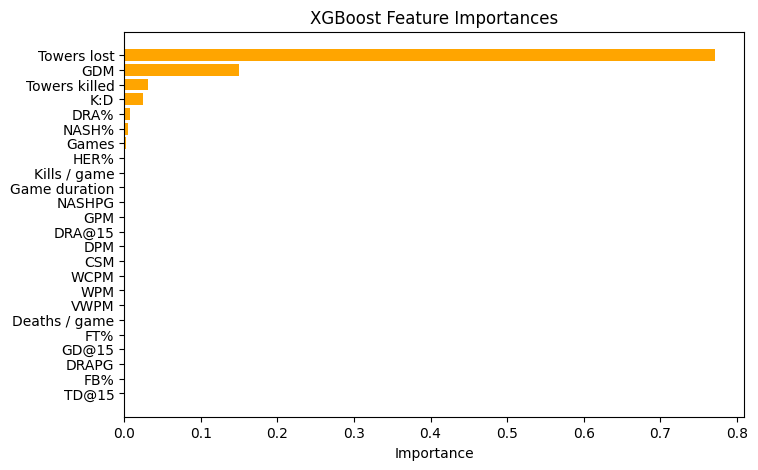

In [16]:
# (c) XGBoost Feature Importances
xgb_importances = best_xgb.feature_importances_
indices_xgb = np.argsort(xgb_importances)[::-1]
plt.figure(figsize=(8, 5))
plt.barh(range(len(features)), xgb_importances[indices_xgb], align='center', color='orange')
plt.yticks(range(len(features)), features[indices_xgb])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.show()

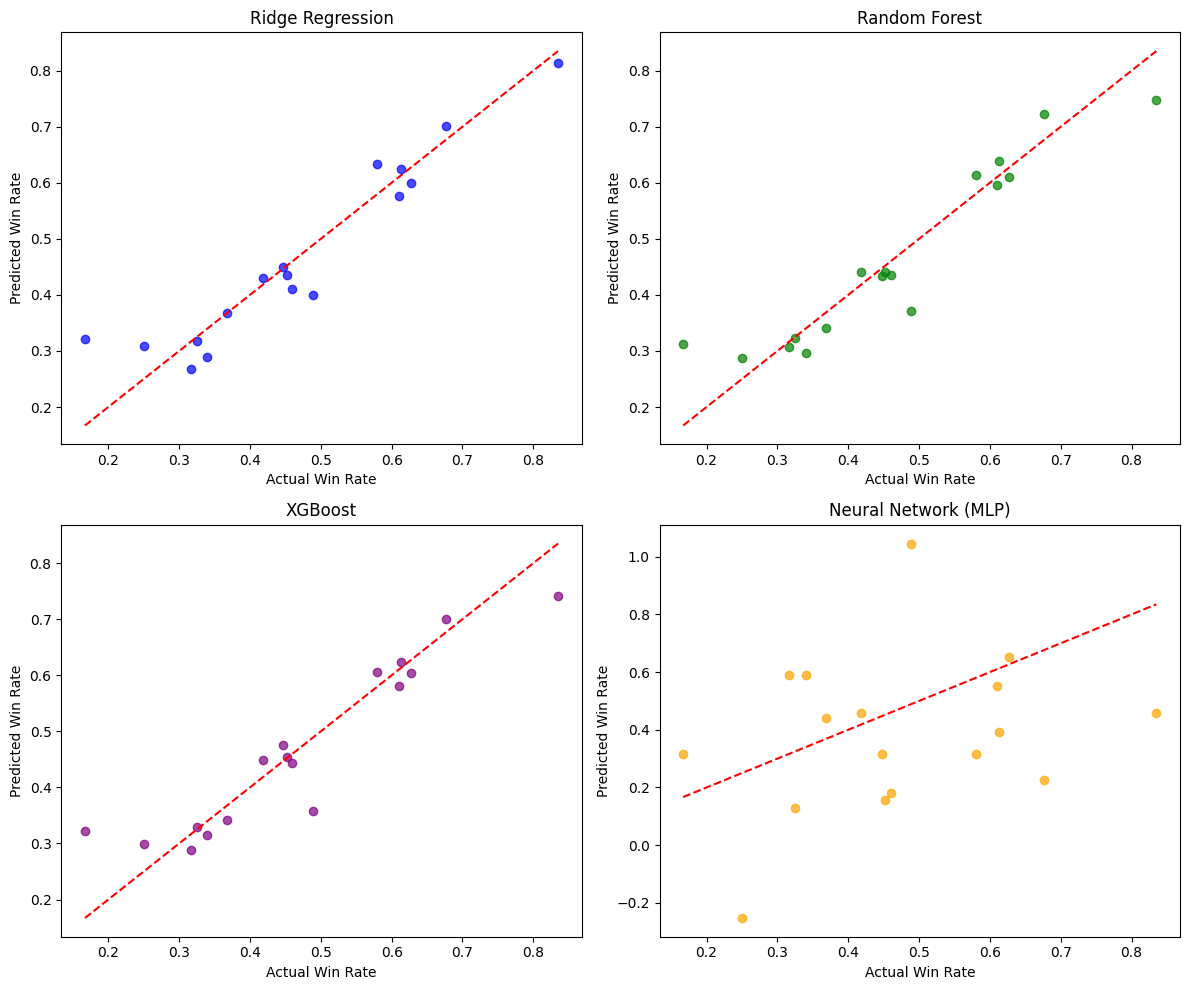

In [17]:
# (d) Actual vs Predicted Win Rates for each model (2x2 grid)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_ridge, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Ridge Regression")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, color='purple', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("XGBoost")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_nn, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Neural Network (MLP)")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

plt.tight_layout()
plt.show()


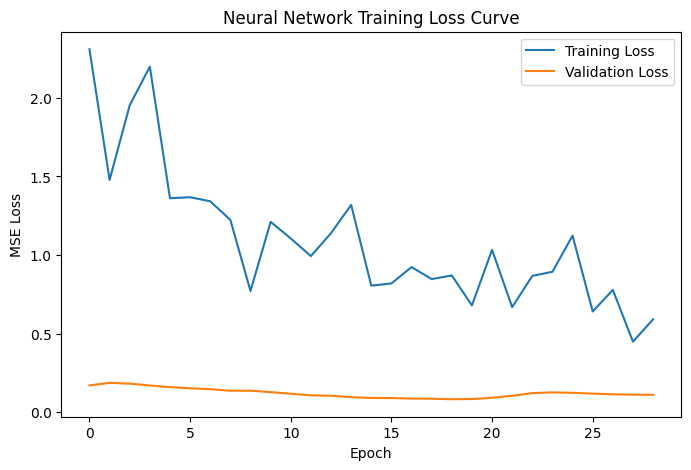

In [18]:
# (e) Neural Network Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network Training Loss Curve")
plt.legend()
plt.show()

In [19]:
# GROUP PLAYERS BY TEAM AND SEASON, USING ALL PLAYERS (with Padding)
# Define player features to be used (all numeric columns except identifiers)
player_feature_cols = [col for col in df_players.columns if col not in ['Team','Season','Player','Position']]

# Group players by Team and Season
groups = df_players.groupby(['Team','Season'])

# Determine the maximum number of players in any team-season.
max_players = groups.size().max()
print("Maximum number of players in any team-season:", max_players)

X_list = []  # list to store each team's players stats matrix
Y_list = []  # list to store corresponding team stats (target)

# Define target columns from the teams DataFrame (exclude identifiers and Win rate if desired)
target_cols = [col for col in df_teams.columns if col not in ['Team','Season','Win rate']]

for (team, season), group in groups:
    # Get all players' stats as a numpy array.
    # Only numeric columns are kept.
    player_stats = group[player_feature_cols].values  # shape: (n, num_features)
    n = player_stats.shape[0]
    # Pad with zeros if n < max_players.
    if n < max_players:
        pad_width = max_players - n
        padding = np.zeros((pad_width, player_stats.shape[1]))
        player_stats = np.vstack([player_stats, padding])
    # If n > max_players, truncate (should not happen as max_players is maximum)
    if player_stats.shape[0] > max_players:
        player_stats = player_stats[:max_players, :]
    X_list.append(player_stats)
    
    # Get corresponding team stats from df_teams for this team and season.
    team_row = df_teams[(df_teams['Team'] == team) & (df_teams['Season'] == season)]
    if team_row.empty:
        continue
    Y_target = team_row[target_cols].values.flatten()  # target vector
    Y_list.append(Y_target)

# Convert lists to numpy arrays.
X_data = np.array(X_list)  # shape: (num_examples, max_players, num_player_features)
Y_data = np.array(Y_list)  # shape: (num_examples, num_team_stats)

Maximum number of players in any team-season: 16


In [20]:
# SPLIT DATA & SCALE FEATURES
# Split the dataset into training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# Flatten the (num_examples, max_players, num_features) to 2D for scaling.
num_train_examples, num_players, num_features = X_train.shape
X_train_flat = X_train.reshape(-1, num_features)
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(-1, num_players, num_features)

# Scale the test data.
X_test_flat = X_test.reshape(-1, num_features)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(-1, num_players, num_features)

In [21]:
# BUILD THE DEEP SETS MODEL WITH TENSORFLOW (USING MASKING)
input_layer = Input(shape=(num_players, num_features))
masked_input = Masking(mask_value=0.0)(input_layer)

# Shared subnetwork for each player's stats.
shared_subnet = Sequential([
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization()
])
player_embeddings = tf.keras.layers.TimeDistributed(shared_subnet)(masked_input)

# Aggregate player embeddings.
aggregated = GlobalAveragePooling1D()(player_embeddings)

# Further mapping to target team stats.
x = Dense(64, activation='relu')(aggregated)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(Y_train.shape[1], activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16, 22)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 16, 22)    │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 16, 22)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 16)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 16, 32)    │      3,936 │ masking[0][0],    │
│ (TimeDistributed)   │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ time_distributed… │
│ (GlobalAveragePool… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 24)        │      1,560 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,864 (30.72 KB)

 Trainable params: 7,544 (29.47 KB)

 Non-trainable params: 320 (1.25 KB)

In [22]:
# TRAIN THE MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, Y_train, 
                    epochs=200, batch_size=16, 
                    validation_split=0.1, callbacks=[early_stop], verbose=1)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 485357.7188 - val_loss: 535097.0625
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 484314.7812 - val_loss: 535094.9375
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 483299.0312 - val_loss: 535078.0625
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 477386.4375 - val_loss: 535063.7500
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 480439.1562 - val_loss: 535052.1250
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 472191.5625 - val_loss: 535036.0625
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 479582.4062 - val_loss: 535031.6875
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 480040.3125 - val_loss: 535024.5625
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 481175.9688 - val_loss: 535006.2500
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 472520.2812 - val_loss: 534989.0625
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4

In [23]:
# EVALUATE THE MODEL
Y_pred = model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
test_r2 = r2_score(Y_test, Y_pred, multioutput='uniform_average')
print(f"Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Test RMSE: 659.935, Test R²: -34.171


In [26]:
# Save the TensorFlow model (mapping players to team stats)
model.save("players_to_team_model.h5")

# Save the linear regression model (win rate prediction)
import joblib
joblib.dump(lin_reg, "win_rate_lin_reg.pkl")


['win_rate_lin_reg.pkl']

In [27]:
model.save("players_to_team_model_fixed.keras")